In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split as tts
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from matplotlib import pyplot as plt

In [19]:
def initialize_dataset(input_file: str) -> tuple:

    dataframe = pd.read_csv(input_file)
    cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
    pre = ['gender', 'group', 'parent_ed', 'lunch', 'prep_course']
    dataframe  = pd.get_dummies(dataframe , columns=cols, prefix=pre, dtype=int)

    # Convert score columns to integers
    dataframe[['math score', 'reading score', 'writing score']] = dataframe[['math score', 'reading score', 'writing score']].astype(int)

    # Create a new column 'passed' based on your condition
    dataframe['passed'] = dataframe.apply(lambda row: 1 if (row['math score'] > 60) & (row['reading score'] > 60) & (row['writing score'] > 60) else -1, axis=1)
    dataframe.drop(['math score', 'reading score', 'writing score'], axis=1, inplace=True)

    x_train, x_test, y_train, y_test = tts(dataframe.drop(['passed'], axis=1), dataframe['passed'], test_size=0.2, random_state=42)

    return (x_train.to_numpy(), y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy())

In [20]:
class SVM:
    def __init__(self, C : float = 0.5, gamma : float = 0.5, kernel : str = 'linear') -> None:
        self.C = C
        self.kernel = {
            'linear': lambda x, y: np.dot(x.T, y),
            'rbf': lambda x, y: np.exp(-gamma * np.linalg.norm(x - y) ** 2)     # lepsza gamma czy sigma?
        }[kernel]
        self.w = 0
        self.b = 0

    def hinge_loss(self, x : np.ndarray, y : np.ndarray, w : np.ndarray, b : float) -> np.ndarray:
        loss = 0.5 * (w * w)                                                    # czy lambda może być równa 1/2 na stałe?
        for i in range(x.shape[0]):
            term = y[i] * (self.kernel(x[i], w) - b)
            loss += self.C * max(1 - term, 0)                                   # czy C jest tutaj dobrze zdefiniowane?
        return loss

    def fit(self, x : np.ndarray, y : np.ndarray, learn_rate : float = 0.01, max_iter : int = 1000) -> tuple:
        losses = []
        samples, features = x.shape
        w = np.random.uniform(-1, 1, features)                                  # jak inicjalizować w?
        b = np.random.uniform(-5, 5)                                            # jak inicjalizować b?

        for _ in range(max_iter):
            loss = self.hinge_loss(x, y, w, b)
            losses.append(loss)                                                 # czy hinge loss musi brać aktywny udział w minimalizacji?
            for i in range(samples):
                term = self.C * y[i] * (self.kernel(x[i], w) - b)
                if term <= 1:
                    w += self.C * (learn_rate * y[i] * x[i])                    # w derivative
                    b -= self.C * learn_rate * y[i]                             # b derivative

        self.w = w
        self.b = b
        return (self.w, self.b, losses)                                          # czy mogę minimalizować w zamiast alfy

    def predict(self, x : np.ndarray) -> np.ndarray:
        return np.sign(np.dot(x, self.w) - self.b)

In [18]:
input_file = "dataset.csv"
x_train, y_train, x_test, y_test = initialize_dataset(input_file)

lib_svc = SVC(kernel='rbf')
lib_svc.fit(x_train, y_train)
prediction = lib_svc.predict(x_test)

print("Lib accuracy:", accuracy_score(prediction, y_test))
print("Lib precision:", precision_score(y_test, prediction))
print("Lib recall:", recall_score(y_test, prediction))
print("Lib confusion Matrix:\n", confusion_matrix(y_test, prediction))

my_svm = SVM(kernel='rbf', C=1.0)
my_svm.fit(x_train, y_train)
prediction = my_svm.predict(x_test)

print("My accuracy:", accuracy_score(prediction, y_test))
print("My precision:", precision_score(y_test, prediction))
print("My recall:", recall_score(y_test, prediction))
print("My confusion Matrix:\n", confusion_matrix(y_test, prediction))


Lib accuracy: 0.61
Lib precision: 0.671875
Lib recall: 0.7049180327868853
Lib confusion Matrix:
 [[18 21]
 [18 43]]
My accuracy: 0.67
My precision: 0.71875
My recall: 0.7540983606557377
My confusion Matrix:
 [[21 18]
 [15 46]]


In [14]:
def draw_graphs():
    c = np.linspace(0.1, 1.2, 20)
    input_file = "dataset.csv"
    x_train, y_train, x_test, y_test = initialize_dataset(input_file)

    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    kernels = ['linear', 'rbf']
    metrics = ['Accuracy', 'Precision', 'Recall']

    for kernel in kernels:
        my_acc = []
        my_prec = []
        my_rec = []
        lib_acc = []
        lib_prec = []
        lib_rec = []

        for i in c:
            my_svm = SVM(kernel=kernel, C=i)
            my_svm.fit(x_train, y_train)
            prediction = my_svm.predict(x_test)

            my_acc.append(accuracy_score(prediction, y_test))
            my_prec.append(precision_score(prediction, y_test))
            my_rec.append(recall_score(prediction, y_test))

            lib_svc = SVC(kernel=kernel, C=i)
            lib_svc.fit(x_train, y_train)
            prediction = lib_svc.predict(x_test)

            lib_acc.append(accuracy_score(prediction, y_test))
            lib_prec.append(precision_score(prediction, y_test))
            lib_rec.append(recall_score(prediction, y_test))

        # Plot accuracy
        axs[0].plot(c, my_acc, label=f'My {kernel} accuracy')
        axs[0].plot(c, lib_acc, label=f'Lib {kernel} accuracy')

        # Plot precision
        axs[1].plot(c, my_prec, label=f'My {kernel} precision')
        axs[1].plot(c, lib_prec, label=f'Lib {kernel} precision')

        # Plot recall
        axs[2].plot(c, my_rec, label=f'My {kernel} recall')
        axs[2].plot(c, lib_rec, label=f'Lib {kernel} recall')

    for ax, metric in zip(axs, metrics):
        ax.set_xlabel('C')
        ax.set_ylabel(metric)
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()


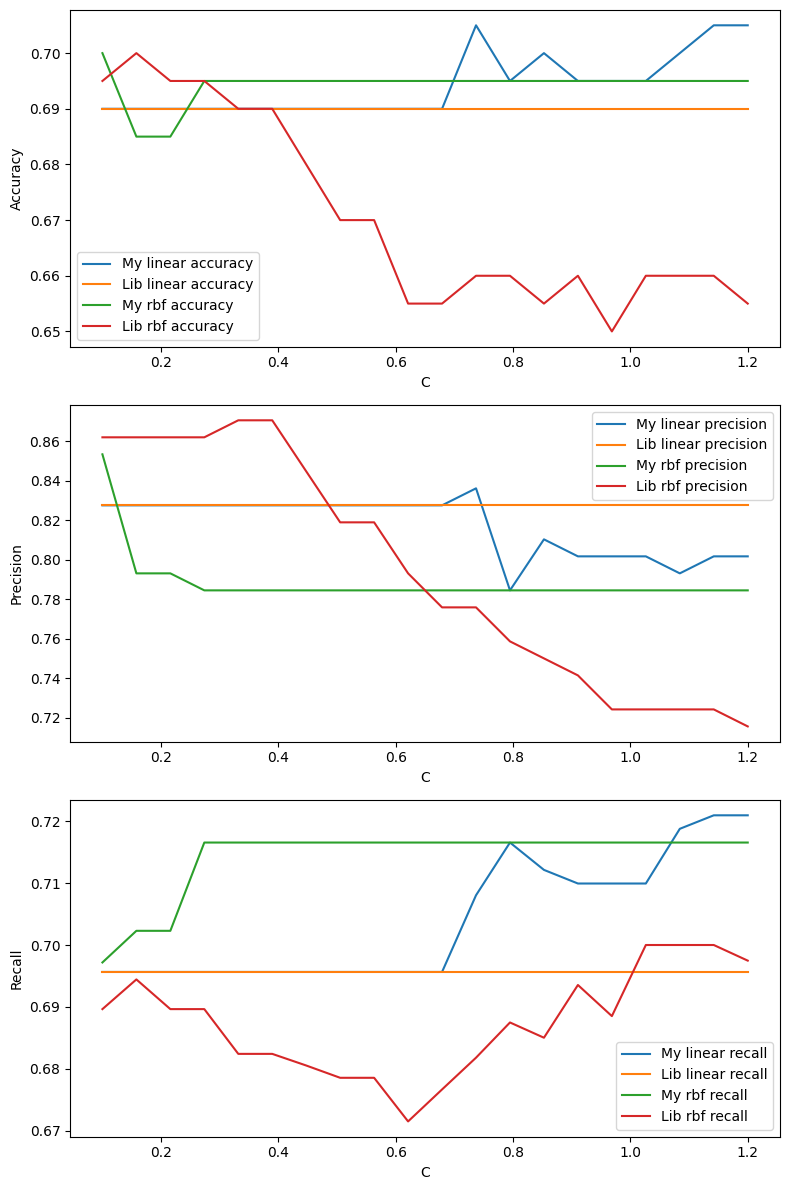

In [15]:
draw_graphs()